In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names=[]
Datasets=dict()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_names.append(os.path.join(dirname,filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ids-intrusion-csv/02-28-2018.csv
/kaggle/input/ids-intrusion-csv/03-01-2018.csv
/kaggle/input/ids-intrusion-csv/02-16-2018.csv
/kaggle/input/ids-intrusion-csv/02-15-2018.csv
/kaggle/input/ids-intrusion-csv/02-21-2018.csv
/kaggle/input/ids-intrusion-csv/03-02-2018.csv
/kaggle/input/ids-intrusion-csv/02-22-2018.csv
/kaggle/input/ids-intrusion-csv/02-20-2018.csv
/kaggle/input/ids-intrusion-csv/02-14-2018.csv
/kaggle/input/ids-intrusion-csv/02-23-2018.csv


1. Training 3 models on the data based on the Logistic Regression Algorithm, the Naive Bayes Algorithm and the Random Forest Algorithm:

    - Logistic regression used here cos it is an algorithm that performs well on binary classification. 
    - Naive Bayes is a probabilistic algorithm also good for binary classification
    - Random forest because of the much features on the dataset to determine from.
    
2. Feature selection on sample of data using feature importance and correllation.
3. Training the new data with the new features on the RandomForest algorithm.
4. comparing accuracy and time.

In [163]:
df_00 = pd.read_csv('/kaggle/input/ids-intrusion-csv/02-15-2018.csv')

In [164]:
df_00.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign


In [165]:
df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

- 80 different columns on the dataset
- 1,000,000+ rows

#### Changing all dtypes into the numpy dtype format

In [166]:
dtypes = {}
for col, dtype in zip(df_00.columns,df_00.dtypes):
    if dtype == np.dtype(int):
        dtypes[col] = np.int64
        
    elif dtype == np.dtype(float):
        dtypes[col] = np.float64
        
    elif dtype == np.dtype('O'):
        dtypes[col] = np.dtype('O')
        
    else:
        dtypes[col] = dtype
    

#### Reading all files into a single data frame and naming the dataframe **data_total**

In [167]:
%time
df_dataset = []
# list for unreadable files 
not_read = []
for path in tqdm(file_names, desc='Reading all the files into a single data frame'):
    if path == '/kaggle/input/ids-intrusion-csv/02-2-2018.csv':
        continue
        # try except block needed here to avoid errors while appending the files 
    try:
        file = pd.read_csv(path, low_memory=False, chunksize=200000, dtype = dtypes).get_chunk()
        df_dataset.append(file)
    except ValueError:
        print('Data in path: {} was not read'.format(path))
        not_read.append(path)
        continue
    
data_total = pd.concat(df_dataset)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


Reading all the files into a single data frame:  10%|█         | 1/10 [00:02<00:19,  2.12s/it]

Data in path: /kaggle/input/ids-intrusion-csv/02-28-2018.csv was not read


Reading all the files into a single data frame:  20%|██        | 2/10 [00:03<00:14,  1.84s/it]

Data in path: /kaggle/input/ids-intrusion-csv/03-01-2018.csv was not read


Reading all the files into a single data frame: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


In [168]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 199999
Data columns (total 84 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1600000 non-null  int64  
 1   Protocol           1600000 non-null  int64  
 2   Timestamp          1600000 non-null  object 
 3   Flow Duration      1600000 non-null  int64  
 4   Tot Fwd Pkts       1600000 non-null  int64  
 5   Tot Bwd Pkts       1600000 non-null  int64  
 6   TotLen Fwd Pkts    1600000 non-null  int64  
 7   TotLen Bwd Pkts    1600000 non-null  int64  
 8   Fwd Pkt Len Max    1600000 non-null  int64  
 9   Fwd Pkt Len Min    1600000 non-null  int64  
 10  Fwd Pkt Len Mean   1600000 non-null  float64
 11  Fwd Pkt Len Std    1600000 non-null  float64
 12  Bwd Pkt Len Max    1600000 non-null  int64  
 13  Bwd Pkt Len Min    1600000 non-null  int64  
 14  Bwd Pkt Len Mean   1600000 non-null  float64
 15  Bwd Pkt Len Std    1600000 non-nu

#### total data has:
    - 1,600, 000 non-null rows
    - 4 new additional columns with only 200,000 non-null rows
    

In [169]:
# checking for the value counts for the different labels we have in the dataset 
data_total['Label'].value_counts()

Benign                      627471
DDoS attacks-LOIC-HTTP      199894
DDOS attack-HOIC            196055
FTP-BruteForce              179244
Bot                         162906
DoS attacks-SlowHTTPTest     91434
DoS attacks-Hulk             67350
DoS attacks-GoldenEye        41508
SSH-Bruteforce               20490
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: Label, dtype: int64

1. All values above are type of attack on the network 
    - Benign labels are the non-attacking labels but were identified as attacks on the network:
        - So will be singled out as not attack.
        - The others will serve as intrusions.

In [170]:
# Dealing with the not_red list and correcting the errors that prevented them from reading 
# in order to concatenate them with the remaining files 
file1 = pd.read_csv('/kaggle/input/ids-intrusion-csv/02-28-2018.csv', low_memory=False, chunksize=200000).get_chunk()

file2 = pd.read_csv('/kaggle/input/ids-intrusion-csv/03-01-2018.csv', low_memory=False, chunksize=200000).get_chunk()

In [171]:
# creating functions to do different tasks
# converting value to float while skipping the errors by using the try except block
def convert(val):
    try:
        return float(val)
    except ValueError:
        return np.nan
    
# correcting the dtypes of the columns based on the d-types dictionary created above
def correct_df(d):
    df = d.copy()
    for col in df.columns:
        try:
            df[col] = df[col].astype(dtypes[col])
        except KeyError:
            continue
        except ValueError:
            df[col] = df[col].apply(convert)
    return df

In [172]:
# passing the dataframe(s) through the function for appropriate corrections
corrected_file1 = correct_df(file1) 
corrected_file2 = correct_df(file2)

In [173]:
# concatenating the two datasets and doing the necessary corrections before adding to the previous dataset
concat_df = pd.concat([corrected_file1, corrected_file2])
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 199999
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           399980 non-null  float64
 1   Protocol           399980 non-null  float64
 2   Timestamp          400000 non-null  object 
 3   Flow Duration      399980 non-null  float64
 4   Tot Fwd Pkts       399980 non-null  float64
 5   Tot Bwd Pkts       399980 non-null  float64
 6   TotLen Fwd Pkts    399980 non-null  float64
 7   TotLen Bwd Pkts    399980 non-null  float64
 8   Fwd Pkt Len Max    399980 non-null  float64
 9   Fwd Pkt Len Min    399980 non-null  float64
 10  Fwd Pkt Len Mean   399980 non-null  float64
 11  Fwd Pkt Len Std    399980 non-null  float64
 12  Bwd Pkt Len Max    399980 non-null  float64
 13  Bwd Pkt Len Min    399980 non-null  float64
 14  Bwd Pkt Len Mean   399980 non-null  float64
 15  Bwd Pkt Len Std    399980 non-null  float64
 16  Fl

1. The two datasets have:
    - 400,000 non-null rows on an average.
    - 79 columns(unlike the previously combined dataset with 83 columns)
2. Since the null rows are not many, they can be left out of the data by dropping them suing the dropna pandas function

In [174]:
concat_df.dropna(inplace=True)

# cross checking if there are still null rows
concat_df.isna().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [175]:
# dtypes correction
for col in concat_df.columns:
    concat_df[col] = concat_df[col].astype(dtypes[col])
    
print(concat_df.dtypes)

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object


In [176]:
concat_df.head(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,28/02/2018 08:22:13,94658,6,7,708,3718,387,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,443,6,28/02/2018 08:22:13,206,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,445,6,28/02/2018 08:22:15,165505,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,443,6,28/02/2018 08:22:16,102429,6,7,708,3718,387,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,443,6,28/02/2018 08:22:16,167,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
5,443,6,28/02/2018 08:22:20,164387,9,7,553,3773,202,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
7,445,6,28/02/2018 08:22:25,131411,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
8,445,6,28/02/2018 08:22:34,279349,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
9,443,6,28/02/2018 08:22:23,20771523,6,8,708,3695,387,0,...,20,222656.0,0.0,222656,222656,20548866.0,0.0,20548866,20548866,Benign
10,443,6,28/02/2018 08:22:44,201,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


#### Concatenating the whole datasets
Note:
1. Both the previously combined dataset and the concat dataset has some redundant columns.
2. The columns will be removed from both before concatenating.

In [177]:
# list of redundant columns
redundant_cols = ["Flow ID","Src IP","Src Port","Dst IP"]
# removal from the total data
data_total.drop(redundant_cols, axis=1, inplace=True)

In [178]:
# concatenating the two pre-combined datasets
data_new = pd.concat([data_total, concat_df])
data_new.head(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734.0,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
5,0,0,16/02/2018 08:35:50,112641178,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,5.656854,56300000,56300000,Benign
6,0,0,16/02/2018 08:38:39,112641264,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,7.071068,56300000,56300000,Benign
7,0,0,16/02/2018 08:41:28,112641525,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,17.677670,56300000,56300000,Benign
8,0,0,16/02/2018 08:44:17,112641414,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,63.639610,56300000,56300000,Benign
9,0,0,16/02/2018 08:47:06,112641379,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,30.405592,56300000,56300000,Benign


In [179]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997539 entries, 0 to 199999
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int64  
 9   Fwd Pkt Len Min    int64  
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    int64  
 13  Bwd Pkt Len Min    int64  
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        float64
 25  Fwd IAT Max        

#### data_new:
    - 1,900,000+ rows
    - 80 different columns
    - appropriate data types
    - 0 null rows

In [180]:
#handling null and infinite values
data_new.replace(np.inf,np.NaN,inplace=True)
data_new.dropna(inplace=True)

In [181]:
# checking our label column for the unique value counts
data_new['Label'].value_counts()

Benign                      966090
DDoS attacks-LOIC-HTTP      199894
DDOS attack-HOIC            196055
FTP-BruteForce              179239
Bot                         162906
DoS attacks-SlowHTTPTest     91434
DoS attacks-Hulk             67350
Infilteration                53866
DoS attacks-GoldenEye        41508
SSH-Bruteforce               20490
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: Label, dtype: int64

In [182]:
# replacing all types except benign as intrusion label
labels = data_new['Label'].unique()
label_dict = {label: 'Intrusion' for label in labels if label != 'Benign'}
data_new['Label'] = data_new['Label'].replace(label_dict)

In [183]:
# checking for the counts of our two new distinct labels
# not normalized
print(data_new['Label'].value_counts())
# normalized
print(data_new['Label'].value_counts(normalize=True))

Intrusion    1026390
Benign        966090
Name: Label, dtype: int64
Intrusion    0.515132
Benign       0.484868
Name: Label, dtype: float64


1. Over 50% of our new data is labelled 'Intrusion'
2. The remaining are 'Benign'

In [184]:
# for easy column accessiblity 
# we are replacing our spaces and slashes with underscores
# and saving as a dictionary(for comparing old and new columns)
columns = data_new.columns
new_columns = {col:col.replace(' ', '_').replace('/', '_') for col in columns}

new_columns

{'Dst Port': 'Dst_Port',
 'Protocol': 'Protocol',
 'Timestamp': 'Timestamp',
 'Flow Duration': 'Flow_Duration',
 'Tot Fwd Pkts': 'Tot_Fwd_Pkts',
 'Tot Bwd Pkts': 'Tot_Bwd_Pkts',
 'TotLen Fwd Pkts': 'TotLen_Fwd_Pkts',
 'TotLen Bwd Pkts': 'TotLen_Bwd_Pkts',
 'Fwd Pkt Len Max': 'Fwd_Pkt_Len_Max',
 'Fwd Pkt Len Min': 'Fwd_Pkt_Len_Min',
 'Fwd Pkt Len Mean': 'Fwd_Pkt_Len_Mean',
 'Fwd Pkt Len Std': 'Fwd_Pkt_Len_Std',
 'Bwd Pkt Len Max': 'Bwd_Pkt_Len_Max',
 'Bwd Pkt Len Min': 'Bwd_Pkt_Len_Min',
 'Bwd Pkt Len Mean': 'Bwd_Pkt_Len_Mean',
 'Bwd Pkt Len Std': 'Bwd_Pkt_Len_Std',
 'Flow Byts/s': 'Flow_Byts_s',
 'Flow Pkts/s': 'Flow_Pkts_s',
 'Flow IAT Mean': 'Flow_IAT_Mean',
 'Flow IAT Std': 'Flow_IAT_Std',
 'Flow IAT Max': 'Flow_IAT_Max',
 'Flow IAT Min': 'Flow_IAT_Min',
 'Fwd IAT Tot': 'Fwd_IAT_Tot',
 'Fwd IAT Mean': 'Fwd_IAT_Mean',
 'Fwd IAT Std': 'Fwd_IAT_Std',
 'Fwd IAT Max': 'Fwd_IAT_Max',
 'Fwd IAT Min': 'Fwd_IAT_Min',
 'Bwd IAT Tot': 'Bwd_IAT_Tot',
 'Bwd IAT Mean': 'Bwd_IAT_Mean',
 'Bwd IAT S

In [185]:
# replacing the columns of the new data with the value of our
# new_columns dictionary using the keys
data_new.rename(new_columns, axis=1, inplace=True)

In [186]:
X = data_new.iloc[:,:-1]
X.drop(['Timestamp'],axis=1,inplace=True)
y = data_new['Label']

In [187]:
# Labelling our binary data 0 and 1 with 
# 0 meaning no intrusion/Benign and 1 meaning Intrusion

y.replace('Benign',0,inplace=True)
y.replace('Intrusion',1,inplace=True)

In [188]:
print(y[y==1].count())
y[y==0].count()

1026390


966090

In [189]:
# Splitting the data for the purpose of cross validation
# named x_training for further splitting into x_train and validation
x_training, x_test, y_training, y_test = train_test_split(X, y, test_size=0.1, random_state=12,
                                               stratify=y)
x_train,x_val, y_train, y_val = train_test_split(x_training, y_training, test_size=0.2, 
                                                 random_state=12, stratify=y_training)

In [190]:
# creating a function to calculate accuracy, precision, recall... and so on
def calculate(y_true, y_preds):
    # classification report
    pre = classification_report(y_true, y_preds)
    print('Classification report:>', pre)
    
    # accuracy
    acc = accuracy_score(y_true, y_preds)
    print('Accuracy:>', acc)
    
    # precision
    pre = precision_score(y_true, y_preds)
    print('Precision:>', pre)


In [191]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [192]:
#predict
rf_preds = rf.predict(x_val)

#evaluate
calculate(y_val, rf_preds)

Classification report:>               precision    recall  f1-score   support

           0       0.95      0.98      0.97    173896
           1       0.98      0.95      0.97    184751

    accuracy                           0.97    358647
   macro avg       0.97      0.97      0.97    358647
weighted avg       0.97      0.97      0.97    358647

Accuracy:> 0.9685038491887566
Precision:> 0.9848063904835905


In [193]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

#predict
xgb_preds = xgb.predict(x_val)


In [194]:
#evaluate
calculate(y_val, xgb_preds)

Classification report:>               precision    recall  f1-score   support

           0       0.95      1.00      0.97    173896
           1       1.00      0.95      0.97    184751

    accuracy                           0.97    358647
   macro avg       0.97      0.97      0.97    358647
weighted avg       0.97      0.97      0.97    358647

Accuracy:> 0.973570112115813
Precision:> 0.9991513356495985


In [195]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

#predict
lr_preds = lr.predict(x_val)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [196]:
#evaluate
calculate(y_val, lr_preds)

Classification report:>               precision    recall  f1-score   support

           0       0.77      0.80      0.78    173896
           1       0.80      0.77      0.79    184751

    accuracy                           0.78    358647
   macro avg       0.78      0.78      0.78    358647
weighted avg       0.78      0.78      0.78    358647

Accuracy:> 0.7831488901343103
Precision:> 0.8002132794522085


- From the above model predictions, we can give the following:
    1. The models are predicting well with 97% approx from random forest
    2. All the features were being used
    3. There are still some complexities in the data(No actual feature has been selected)

**Feature Selection**

Some features need to be dropped to minimize the complexity of our data.
The source of the dataset listed some of the most important features. Below are the columns that are of most importance according to the source:

* Dst Port (Destination port)
* Protocol
* Flow Duration
* Tot Fwd Pkts (Total forward packets)
* Tot Bwd Pkts (Total backward packets)

**Dividing the work int 2 parts:**

1. We will use only the above columns selected by the source for prediction and check the performance of the models.
2. We will will drop some columns(feature selection) that are most likely inter-dependent and find the feature importance and use the most important features to predict.
3. We will then we compare both performance.

In [197]:
# Finding the correlation and drawing as an HeatMap
corr = data_new.corr()
corr

/tmp/ipykernel_32/2122842075.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_new.corr()


,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
Dst_Port,1.000000,-0.155562,-0.007369,-0.011164,-0.008161,-0.005575,-0.006000,0.096693,-0.083848,0.054539,...,0.015871,-0.020472,-0.017823,-0.023615,-0.015871,0.105948,-0.027711,0.099704,0.109996,-0.272657
Protocol,-0.155562,1.000000,-0.137637,0.064749,-0.010360,0.047885,-0.006530,-0.148524,0.587718,0.054835,...,-0.586142,-0.046425,-0.050481,-0.054322,-0.030897,-0.127859,0.012780,-0.120917,-0.130675,-0.375586
Flow_Duration,-0.007369,-0.137637,1.000000,0.115692,0.057911,0.086808,0.042263,0.162820,0.038931,0.093219,...,-0.117124,0.194075,0.174523,0.230188,0.148453,0.734484,0.297296,0.754742,0.707661,-0.237127
Tot_Fwd_Pkts,-0.011164,0.064749,0.115692,1.000000,0.015895,0.735604,0.009072,-0.010724,0.023602,-0.002622,...,-0.041489,-0.000761,-0.000160,-0.000521,-0.000759,-0.007023,-0.002267,-0.007142,-0.006842,0.027300
Tot_Bwd_Pkts,-0.008161,-0.010360,0.057911,0.015895,1.000000,0.218461,0.948411,0.062403,-0.007705,0.039414,...,-0.004198,0.035346,0.022769,0.042245,0.032656,0.023284,0.023106,0.024609,0.021070,-0.019360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle_Mean,0.105948,-0.127859,0.734484,-0.007023,0.023284,-0.004567,0.020545,0.030155,-0.008242,0.002437,...,-0.070556,0.063363,0.046160,0.065704,0.052718,1.000000,0.142494,0.991148,0.995176,-0.163345
Idle_Std,-0.027711,0.012780,0.297296,-0.002267,0.023106,-0.000143,0.020499,0.063834,0.277734,0.200345,...,-0.018289,0.229117,0.172783,0.232587,0.185306,0.142494,1.000000,0.266303,0.046806,-0.035436
Idle_Max,0.099704,-0.120917,0.754742,-0.007142,0.024609,-0.004491,0.021726,0.036856,0.035827,0.032673,...,-0.070645,0.093155,0.065845,0.094942,0.078111,0.991148,0.266303,1.000000,0.974052,-0.161842
Idle_Min,0.109996,-0.130675,0.707661,-0.006842,0.021070,-0.004656,0.018666,0.022672,-0.038989,-0.019155,...,-0.068914,0.041380,0.030017,0.043226,0.034664,0.995176,0.046806,0.974052,1.000000,-0.160474


<Axes: >

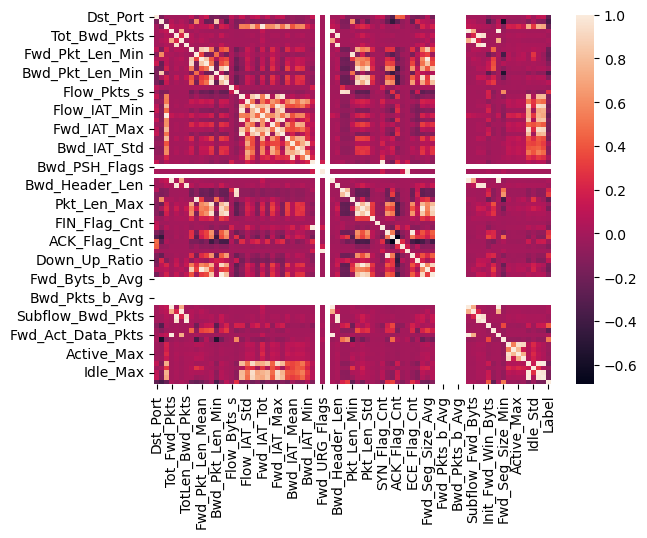

In [198]:
import seaborn as sns
sns.heatmap(corr)

**Note:**
- According to the graph above:
        1. There are some columns that are interdependent on each other.
        2. The map on the right side shows the correlation value.
        3. White being the strongest.

1. The whiteness on the map shows perfect colinearity(1), meaning that a feature is perfectly colinear with another feature. This means that they are completely dependent on each other.
2. The columns will be dropped.

In [199]:
# These columns are going to be dropped because according to the map
# Most columns with perfect colinearity are columns with the suffixes:
#   - _Max,
#   - _Min,
#   - _Mean,
#   - _Avg
    
dropped_cols = [col for col in data_new.columns if col.split('_')[-1] in ['Min', 'Max', 'Mean','Avg', 'Std', 'Cnt']]

print(dropped_cols)
print(len(dropped_cols))

['Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Std', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Std', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt', 'ECE_Flag_Cnt', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Bwd_Seg_Size_Avg', 'Fwd_Byts_b_Avg', 'Fwd_Pkts_b_Avg', 'Fwd_Blk_Rate_Avg', 'Bwd_Byts_b_Avg', 'Bwd_Pkts_b_Avg', 'Bwd_Blk_Rate_Avg', 'Fwd_Seg_Size_Min', 'Active_Mean', 'Active_Std', 'Active_Max', 'Active_Min', 'Idle_Mean', 'Idle_Std', 'Idle_Max', 'Idle_Min']
49


49 columns are in this category and are going to be dropped.

In [200]:
data = data_new.drop(dropped_cols, axis=1)

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992480 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst_Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow_Duration      int64  
 4   Tot_Fwd_Pkts       int64  
 5   Tot_Bwd_Pkts       int64  
 6   TotLen_Fwd_Pkts    int64  
 7   TotLen_Bwd_Pkts    int64  
 8   Flow_Byts_s        float64
 9   Flow_Pkts_s        float64
 10  Fwd_IAT_Tot        int64  
 11  Bwd_IAT_Tot        int64  
 12  Fwd_PSH_Flags      int64  
 13  Bwd_PSH_Flags      int64  
 14  Fwd_URG_Flags      int64  
 15  Bwd_URG_Flags      int64  
 16  Fwd_Header_Len     int64  
 17  Bwd_Header_Len     int64  
 18  Fwd_Pkts_s         float64
 19  Bwd_Pkts_s         float64
 20  Pkt_Len_Var        float64
 21  CWE_Flag_Count     int64  
 22  Down_Up_Ratio      int64  
 23  Subflow_Fwd_Pkts   int64  
 24  Subflow_Fwd_Byts   int64  
 25  Subflow_Bwd_Pkts   

We are left with 30 columns for prediction

In [202]:
# data segmentation
X = data.drop(['Timestamp', 'Label'], axis=1)
y = data['Label']
# Splitting the data for the purpose of cross validation
train, X_test, label, y_test = train_test_split(X, y, test_size=0.1, random_state=12,
                                               stratify=y)

#### Finding the relevance of the features

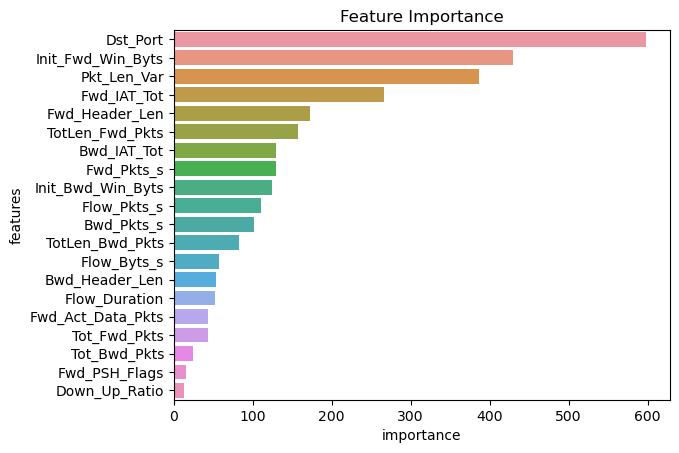

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt


#Initializing the feature selection model. 
featureModel = LGBMClassifier(random_seed=12)

#Fitting the model on our sets of features
results = featureModel.fit(train, label)

# Relevance of the features
feat_imp = pd.DataFrame({'features':results.feature_name_,
                         'importance': results.feature_importances_}).set_index('features')\
                        .sort_values('importance', ascending=False)

top_20 = feat_imp.head(20)
sns.barplot(y=top_20.index, x=top_20['importance'], orient='h')
plt.title('Feature Importance');

In [204]:
top_20

,importance
features,
Dst_Port,598
Init_Fwd_Win_Byts,429
Pkt_Len_Var,387
Fwd_IAT_Tot,266
Fwd_Header_Len,173
TotLen_Fwd_Pkts,157
Bwd_IAT_Tot,130
Fwd_Pkts_s,129
Init_Bwd_Win_Byts,125


We will be making use of the columns with count greater than 50/ top 15

In [205]:
imp_cols = feat_imp.iloc[:15].index

In [206]:
# Splitting the data for the purpose of cross validation
train, X_test, label, y_test = train_test_split(X[imp_cols], y, test_size=0.1, random_state=12,
                                               stratify=y)
X_train,X_val, y_train, y_val = train_test_split(train, label, test_size=0.2, 
                                                 random_state=12, stratify=label)

#### Building a model on the selected columns

In [207]:
%%time
rf.fit(X_train, y_train)

#predict
rf_preds = rf.predict(X_val)

CPU times: user 12min 9s, sys: 147 ms, total: 12min 9s
Wall time: 12min 9s


In [208]:
#evaluate
calculate(y_val, rf_preds)

Classification report:>               precision    recall  f1-score   support

           0       0.95      0.98      0.97    173896
           1       0.98      0.95      0.97    184751

    accuracy                           0.97    358647
   macro avg       0.97      0.97      0.97    358647
weighted avg       0.97      0.97      0.97    358647

Accuracy:> 0.9679350447654658
Precision:> 0.9833715564334778


#### Calculating the time taken for training and prediction 

In [209]:
%%time
import time

# training time
start_time = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
end_time = time.time()

print("Training Time: {} seconds".format(end_time - start_time))

# prediction time
start_time = time.time()
rf_preds = rf.predict(X_val)
end_time = time.time()
print("Prediction Time: {} seconds".format(end_time - start_time))

# calculate
calculate(y_val, rf_preds)

Training Time: 675.811140537262 seconds
Prediction Time: 10.301063537597656 seconds
Classification report:>               precision    recall  f1-score   support

           0       0.95      0.98      0.97    173896
           1       0.98      0.95      0.97    184751

    accuracy                           0.97    358647
   macro avg       0.97      0.97      0.97    358647
weighted avg       0.97      0.97      0.97    358647

Accuracy:> 0.9679489860503503
Precision:> 0.9834205738903335
CPU times: user 11min 25s, sys: 518 ms, total: 11min 26s
Wall time: 11min 26s


In [210]:
a = accuracy_score(y_val, rf_preds)
a

0.9679489860503503

#### Building a model based on the features from the source

In [211]:
data_source = data_new[['Dst_Port',
'Protocol',
'Flow_Duration',
'Tot_Fwd_Pkts',
'Tot_Bwd_Pkts',
'Label']]

In [212]:
data_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992480 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column         Dtype
---  ------         -----
 0   Dst_Port       int64
 1   Protocol       int64
 2   Flow_Duration  int64
 3   Tot_Fwd_Pkts   int64
 4   Tot_Bwd_Pkts   int64
 5   Label          int64
dtypes: int64(6)
memory usage: 106.4 MB


In [213]:
X = data_source[['Dst_Port',
'Protocol',
'Flow_Duration',
'Tot_Fwd_Pkts',
'Tot_Bwd_Pkts']]
y = data_source['Label']

In [214]:
# # Splitting the data for the purpose of cross validation
train, X_test, label, y_test = train_test_split(X, y, test_size=0.1, random_state=12,
                                               stratify=y)
X_train,X_val, y_train, y_val = train_test_split(train, label, test_size=0.2, 
                                                 random_state=12, stratify=label)

In [215]:
%%time
rf.fit(X_train, y_train)

#predict
rf_preds_source = rf.predict(X_val)

CPU times: user 8min 8s, sys: 36.5 ms, total: 8min 8s
Wall time: 8min 8s


In [216]:
#calculate
calculate(y_val, rf_preds_source)

Classification report:>               precision    recall  f1-score   support

           0       0.94      0.97      0.96    173896
           1       0.97      0.95      0.96    184751

    accuracy                           0.96    358647
   macro avg       0.96      0.96      0.96    358647
weighted avg       0.96      0.96      0.96    358647

Accuracy:> 0.9558646803123964
Precision:> 0.9675756770521934


In [217]:
b = accuracy_score(y_val, rf_preds_source)
b

0.9558646803123964

### Comparison between the feature selected model according to our feature importance and the source

In [218]:
acc_dict = {"Selected Features":a,
           "Source Selected Features":b}
acc_dict

{'Selected Features': 0.9679489860503503,
 'Source Selected Features': 0.9558646803123964}

(0.9, 1.0)

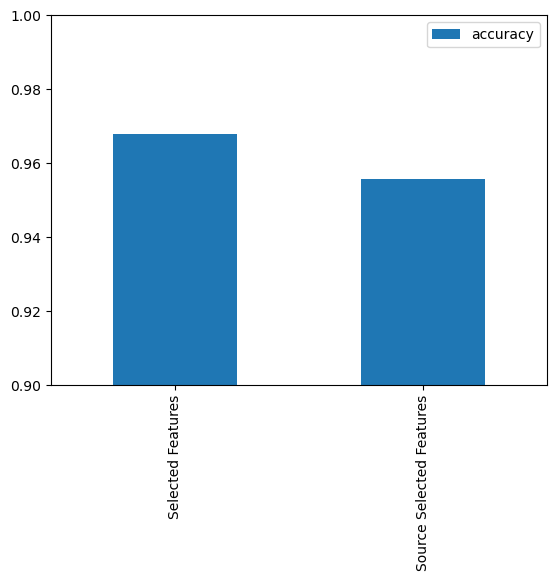

In [221]:
df = pd.DataFrame(acc_dict.values(), index=acc_dict.keys(), columns=["accuracy"])
df.plot(kind='bar')
plt.ylim((0.9,1))